N =  10


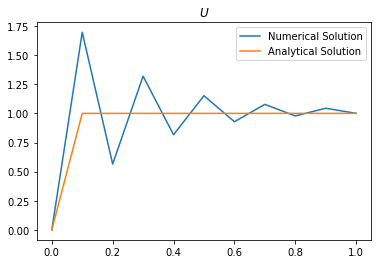

N =  100


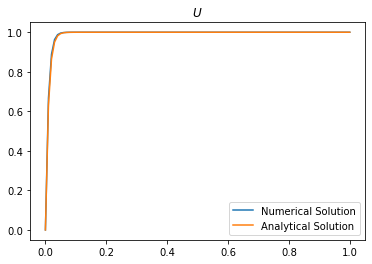

In [11]:
# https://folk.uio.no/kent-and/sommerskole/material/book_20april.pdf
# CG
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

for N in [10, 100]:

    mesh = UnitIntervalMesh(N)
    V = FunctionSpace(mesh, "CG", 1)

    u = TrialFunction(V)
    v = TestFunction(V)

    mu_value = 1.0e-2
    mu = Constant(mu_value)
    f = Constant(0)
    h = mesh.hmin()

    a = (-u.dx(0)*v + mu*u.dx(0)*v.dx(0))*dx
    L = f*v*dx

    u_analytical = Expression("(exp(-x[0]/mu_value) - 1)/ (exp(-1/mu_value) - 1)", degree=1, mu_value=mu_value) 

    def boundary(x):
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

    bc = DirichletBC(V, u_analytical, boundary)

    U = Function(V)

    solve(a == L, U, bc)

    U_analytical = project(u_analytical, V)
    print("N = ", N)
    plot (U, title = r"$U$", rescale = True)
    plot (U_analytical, title = r"$U$", rescale = True)
    plt.legend(["Numerical Solution", "Analytical Solution"])
    plt.show ()

    # plt.figure (1, figsize = (8, 4))
    # plot (U, title = r"$U$", rescale = True)

    # plt.legend(["N=10", "N=100"])

    # plt.figure (2, figsize = (8, 4))
    # plot (U_analytical, title = r"$U_{analytical}$", rescale = True)


Calling FFC just-in-time (JIT) compiler, this may take some time.
N =  10


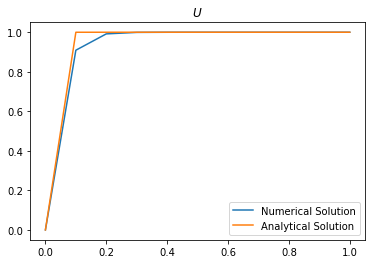

Calling FFC just-in-time (JIT) compiler, this may take some time.
N =  100


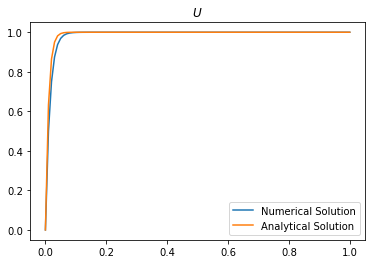

In [1]:
# https://folk.uio.no/kent-and/sommerskole/material/book_20april.pdf
# CG with difussion
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

for N in [10, 100]:

    mesh = UnitIntervalMesh(N)
    V = FunctionSpace(mesh, "CG", 1)

    u = TrialFunction(V)
    v = TestFunction(V)

    mu_value = 1.0e-2
    beta_value = 0.5
    beta = Constant(beta_value)
    mu = Constant(mu_value)
    f = Constant(0)
    h = mesh.hmin()

    a = (-u.dx(0)*v + mu*u.dx(0)*v.dx(0) + beta*h*u.dx(0)*v.dx(0))*dx
    L = f*v*dx

    u_analytical = Expression("(exp(-x[0]/mu_value) - 1)/ (exp(-1/mu_value) - 1)", degree=1, mu_value=mu_value) 

    def boundary(x):
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

    bc = DirichletBC(V, u_analytical, boundary)

    U = Function(V)

    solve(a == L, U, bc)

    U_analytical = project(u_analytical, V)
    print("N = ", N)
    plot (U, title = r"$U$", rescale = True)
    plot (U_analytical, title = r"$U$", rescale = True)
    plt.legend(["Numerical Solution", "Analytical Solution"])
    plt.show ()

    # plt.figure (1, figsize = (8, 4))
    # plot (U, title = r"$U$", rescale = True)

    # plt.legend(["N=10", "N=100"])

    # plt.figure (2, figsize = (8, 4))
    # plot (U_analytical, title = r"$U_{analytical}$", rescale = True)



In [15]:
from dolfin import *
from numpy import linalg

for D in [1, 2]:
    for N in [4, 8, 16, 32]:
        if D == 1: mesh = UnitIntervalMesh(N)
        elif D == 2: mesh = UnitSquareMesh(N, N)

        V = FunctionSpace(mesh, "Lagrange", 1)
        u = TrialFunction(V)
        v = TestFunction(V)

        a = u*v*dx + inner(grad(u), grad(v))*dx
        A = assemble(a)
        e = linalg.eigvals(A.array())
        e.sort()
        c = e[-1] / e[0]

        print ("D=",D, "N=", N, "min eigenvalue=", e[0], "max eigenvalue=", e[-1] ,"cond. number=", c)

D= 1 N= 4 min eigenvalue= 0.19936608889269353 max eigenvalue= 14.561938315909046 cond. number= 73.041199718508
D= 1 N= 8 min eigenvalue= 0.11099773525671823 max eigenvalue= 31.078426523553432 cond. number= 279.99153722978673
D= 1 N= 16 min eigenvalue= 0.05880656718420146 max eigenvalue= 63.47626470711916 cond. number= 1079.4077557407948
D= 1 N= 32 min eigenvalue= 0.030300709003717025 max eigenvalue= 127.72066259186437 cond. number= 4215.104754684015
D= 2 N= 4 min eigenvalue= 0.03973216280235794 max eigenvalue= 7.089949173886577 cond. number= 178.44357502395562
D= 2 N= 8 min eigenvalue= 0.012319896839946942 max eigenvalue= 7.735332653445387 cond. number= 627.8731676034636
D= 2 N= 16 min eigenvalue= 0.003458194786695193 max eigenvalue= 7.929025832076105 cond. number= 2292.822215388694
D= 2 N= 32 min eigenvalue= 0.0009181325515020891 max eigenvalue= 7.981652367777129 cond. number= 8693.355174826265


In [ ]:
"""
FEniCS tutorial demo program: Poisson equation with a combination of
Dirichlet, Neumann, and Robin boundary conditions.

  -div(kappa*grad(u)) = f

This program illustrates a number of different topics:

- How to solve a problem using three different approaches of varying
  complexity: solve / LinearVariationalSolver / assemble + solve
- How to compute fluxes
- How to set combinations of boundary conditions
- How to set parameters for linear solvers
- How to create manufactured solutions with SymPy
- How to create unit tests
- How to represent solutions as structured fields
"""

from __future__ import print_function

from fenics import *
from boxfield import *
import numpy as np

#---------------------------------------------------------------------
# Solvers
#---------------------------------------------------------------------

def solver(kappa, f, u_D, Nx, Ny,
           degree=1,
           linear_solver='Krylov',
           abs_tol=1E-5,
           rel_tol=1E-3,
           max_iter=1000):
    """
    Solve -div(kappa*grad(u) = f on (0, 1) x (0, 1) with 2*Nx*Ny Lagrange
    elements of specified degree and u = u_D on the boundary.
    """

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = kappa*dot(grad(u), grad(v))*dx
    L = f*v*dx

    # Set linear solver parameters
    prm = LinearVariationalSolver.default_parameters()
    if linear_solver == 'Krylov':
        prm.linear_solver = 'gmres'
        prm.preconditioner = 'ilu'
        prm.krylov_solver.absolute_tolerance = abs_tol
        prm.krylov_solver.relative_tolerance = rel_tol
        prm.krylov_solver.maximum_iterations = max_iter
    else:
        prm.linear_solver = 'lu'

    # Compute solution
    u = Function(V)
    solve(a == L, u, bc, solver_parameters=prm)

    return u

def solver_objects(kappa, f, u_D, Nx, Ny,
                   degree=1,
                   linear_solver='Krylov',
                   abs_tol=1E-5,
                   rel_tol=1E-3,
                   max_iter=1000):
    "Same as the solver() function but using LinearVariationalSolver"

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = kappa*dot(grad(u), grad(v))*dx
    L = f*v*dx

    # Compute solution
    u = Function(V)
    problem = LinearVariationalProblem(a, L, u, bc)
    solver = LinearVariationalSolver(problem)

    # Set linear solver parameters
    prm = solver.parameters
    if linear_solver == 'Krylov':
        prm.linear_solver = 'gmres'
        prm.preconditioner = 'ilu'
        prm.krylov_solver.absolute_tolerance = abs_tol
        prm.krylov_solver.relative_tolerance = rel_tol
        prm.krylov_solver.maximum_iterations = max_iter
    else:
        prm.linear_solver = 'lu'

    # Compute solution
    solver.solve()

    return u

def solver_linalg(kappa, f, u_D, Nx, Ny,
                 degree=1,
                 linear_solver='Krylov',
                 abs_tol=1E-5,
                 rel_tol=1E-3,
                 max_iter=1000):
    "Same as the solver() function but assembling and solving Ax = b"

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = kappa*dot(grad(u), grad(v))*dx
    L = f*v*dx

    # Assemble linear system
    A = assemble(a)
    b = assemble(L)

    # Apply boundary conditions
    bc.apply(A, b)

    # Create linear solver and set parameters
    if linear_solver == 'Krylov':
        solver = KrylovSolver('gmres', 'ilu')
        solver.parameters.absolute_tolerance = abs_tol
        solver.parameters.relative_tolerance = rel_tol
        solver.parameters.maximum_iterations = max_iter
    else:
        solver = LUSolver()

    # Compute solution
    u = Function(V)
    solver.solve(A, u.vector(), b)

    return u

def solver_bcs(kappa, f, boundary_conditions, Nx, Ny,
               degree=1,
               subdomains=[],
               linear_solver='Krylov',
               abs_tol=1E-5,
               rel_tol=1E-3,
               max_iter=1000):
    """
    Solve -div(kappa*grad(u) = f on (0, 1) x (0, 1) with 2*Nx*Ny Lagrange
    elements of specified degree and u = u_D on the boundary. This version
    of the solver uses a specified combination of Dirichlet, Neumann, and
    Robin boundary conditions.
    """

    # Create mesh and define function space
    mesh = UnitSquareMesh(Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Check if we have subdomains
    if subdomains:
        if not isinstance(kappa, (list, tuple, np.ndarray)):
            raise TypeError(
                'kappa must be array if we have sudomains, not %s'
                % type(kappa))
        materials = CellFunction('size_t', mesh)
        materials.set_all(0)
        for m, subdomain in enumerate(subdomains[1:], 1):
            subdomain.mark(materials, m)

        kappa_values = kappa
        V0 = FunctionSpace(mesh, 'DG', 0)
        kappa  = Function(V0)
        help = np.asarray(materials.array(), dtype=np.int32)
        kappa.vector()[:] = np.choose(help, kappa_values)
    else:
        if not isinstance(kappa, (Expression, Constant)):
            raise TypeError(
                'kappa is type %s, must be Expression or Constant'
                % type(kappa))

    # Define boundary subdomains
    tol = 1e-14

    class BoundaryX0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1, tol)

    class BoundaryY0(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)

    class BoundaryY1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1, tol)

    # Mark boundaries
    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    by0 = BoundaryY0()
    by1 = BoundaryY1()
    bx0.mark(boundary_markers, 0)
    bx1.mark(boundary_markers, 1)
    by0.mark(boundary_markers, 2)
    by1.mark(boundary_markers, 3)

    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Collect Dirichlet conditions
    bcs = []
    for i in boundary_conditions:
        if 'Dirichlet' in boundary_conditions[i]:
            bc = DirichletBC(V, boundary_conditions[i]['Dirichlet'],
                             boundary_markers, i)
            bcs.append(bc)

    debug1 = False
    if debug1:

        # Print all vertices that belong to the boundary parts
        for x in mesh.coordinates():
            if bx0.inside(x, True): print('%s is on x = 0' % x)
            if bx1.inside(x, True): print('%s is on x = 1' % x)
            if by0.inside(x, True): print('%s is on y = 0' % x)
            if by1.inside(x, True): print('%s is on y = 1' % x)

        # Print the Dirichlet conditions
        print('Number of Dirichlet conditions:', len(bcs))
        if V.ufl_element().degree() == 1:  # P1 elements
            d2v = dof_to_vertex_map(V)
            coor = mesh.coordinates()
            for i, bc in enumerate(bcs):
                print('Dirichlet condition %d' % i)
                boundary_values = bc.get_boundary_values()
                for dof in boundary_values:
                    print('   dof %2d: u = %g' % (dof, boundary_values[dof]))
                    if V.ufl_element().degree() == 1:
                        print('    at point %s' %
                              (str(tuple(coor[d2v[dof]].tolist()))))

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Collect Neumann integrals
    integrals_N = []
    for i in boundary_conditions:
        if 'Neumann' in boundary_conditions[i]:
            if boundary_conditions[i]['Neumann'] != 0:
                g = boundary_conditions[i]['Neumann']
                integrals_N.append(g*v*ds(i))

    # Collect Robin integrals
    integrals_R_a = []
    integrals_R_L = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R_a.append(r*u*v*ds(i))
            integrals_R_L.append(r*s*v*ds(i))

    # Simpler Robin integrals
    integrals_R = []
    for i in boundary_conditions:
        if 'Robin' in boundary_conditions[i]:
            r, s = boundary_conditions[i]['Robin']
            integrals_R.append(r*(u - s)*v*ds(i))

    # Sum integrals to define variational problem
    a = kappa*dot(grad(u), grad(v))*dx + sum(integrals_R_a)
    L = f*v*dx - sum(integrals_N) + sum(integrals_R_L)

    # Simpler variational problem
    F = kappa*dot(grad(u), grad(v))*dx + \
        sum(integrals_R) - f*v*dx + sum(integrals_N)
    a, L = lhs(F), rhs(F)

    # Set linear solver parameters
    prm = LinearVariationalSolver.default_parameters()
    if linear_solver == 'Krylov':
        prm.linear_solver = 'gmres'
        prm.preconditioner = 'ilu'
        prm.krylov_solver.absolute_tolerance = abs_tol
        prm.krylov_solver.relative_tolerance = rel_tol
        prm.krylov_solver.maximum_iterations = max_iter
    else:
        prm.linear_solver = 'lu'

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs, solver_parameters=prm)

    return u

#---------------------------------------------------------------------
# Utility functions
#---------------------------------------------------------------------

def compute_errors(u_e, u):
    """Compute various measures of the error u - u_e, where
    u is a finite element Function and u_e is an Expression."""

    # Get function space
    V = u.function_space()

    # Explicit computation of L2 norm
    error = (u - u_e)**2*dx
    E1 = sqrt(abs(assemble(error)))

    # Explicit interpolation of u_e onto the same space as u
    u_e_ = interpolate(u_e, V)
    error = (u - u_e_)**2*dx
    E2 = sqrt(abs(assemble(error)))

    # Explicit interpolation of u_e to higher-order elements.
    # u will also be interpolated to the space Ve before integration
    Ve = FunctionSpace(V.mesh(), 'P', 5)
    u_e_ = interpolate(u_e, Ve)
    error = (u - u_e)**2*dx
    E3 = sqrt(abs(assemble(error)))

    # Infinity norm based on nodal values
    u_e_ = interpolate(u_e, V)
    E4 = abs(u_e_.vector().array() - u.vector().array()).max()

    # L2 norm
    E5 = errornorm(u_e, u, norm_type='L2', degree_rise=3)

    # H1 seminorm
    E6 = errornorm(u_e, u, norm_type='H10', degree_rise=3)

    # Collect error measures in a dictionary with self-explanatory keys
    errors = {'u - u_e': E1,
              'u - interpolate(u_e, V)': E2,
              'interpolate(u, Ve) - interpolate(u_e, Ve)': E3,
              'infinity norm (of dofs)': E4,
              'L2 norm': E5,
              'H10 seminorm': E6}

    return errors

def compute_convergence_rates(u_e, f, u_D, kappa,
                              max_degree=3, num_levels=5):
    "Compute convergences rates for various error norms"

    h = {}  # discretization parameter: h[degree][level]
    E = {}  # error measure(s): E[degree][level][error_type]

    # Iterate over degrees and mesh refinement levels
    degrees = range(1, max_degree + 1)
    for degree in degrees:
        n = 8  # coarsest mesh division
        h[degree] = []
        E[degree] = []
        for i in range(num_levels):
            h[degree].append(1.0 / n)
            u = solver(kappa, f, u_D, n, n, degree, linear_solver='direct')
            errors = compute_errors(u_e, u)
            E[degree].append(errors)
            print('2 x (%d x %d) P%d mesh, %d unknowns, E1 = %g' %
              (n, n, degree, u.function_space().dim(), errors['u - u_e']))
            n *= 2

    # Compute convergence rates
    from math import log as ln  # log is a fenics name too
    etypes = list(E[1][0].keys())
    rates = {}
    for degree in degrees:
        rates[degree] = {}
        for error_type in sorted(etypes):
            rates[degree][error_type] = []
            for i in range(1, num_levels):
                Ei = E[degree][i][error_type]
                Eim1 = E[degree][i - 1][error_type]
                r = ln(Ei / Eim1) / ln(h[degree][i] / h[degree][i - 1])
                rates[degree][error_type].append(round(r, 2))

    return etypes, degrees, rates

def flux(u, kappa):
    "Return -kappa*grad(u) projected into same space as u"
    V = u.function_space()
    mesh = V.mesh()
    degree = V.ufl_element().degree()
    W = VectorFunctionSpace(mesh, 'P', degree)
    flux_u = project(-kappa*grad(u), W)
    return flux_u

def normalize_solution(u):
    "Normalize u: return u divided by max(u)"
    u_array = u.vector().array()
    u_max = np.max(np.abs(u_array))
    u_array /= u_max
    u.vector()[:] = u_array
    #u.vector().set_local(u_array)  # alternative
    return u

#---------------------------------------------------------------------
# Unit tests (functions beginning with test_)
# These unit tests can be run by calling `py.test poisson_extended.py`
#---------------------------------------------------------------------

def test_solvers():
    "Reproduce exact solution to machine precision with different solvers"

    solver_functions = (solver, solver_objects, solver_linalg)
    tol = {'direct': {1: 1E-11, 2: 1E-11, 3: 1E-11},
           'Krylov': {1: 1E-14, 2: 1E-05, 3: 1E-03}}
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
    kappa = Expression('x[0] + x[1]', degree=1)
    f = Expression('-8*x[0] - 10*x[1]', degree=1)
    for Nx, Ny in [(3, 3), (3, 5), (5 ,3)]:
        for degree in 1, 2, 3:
            for linear_solver in 'direct', 'Krylov':
                for solver_function in solver_functions:
                    print('solving on 2 x (%d x %d) mesh with P%d elements'
                          % (Nx, Ny, degree)),
                    print(' %s solver, %s function' %
                          (linear_solver, solver_function.__name__))
                    u = solver_function(kappa, f, u_D, Nx, Ny, degree,
                                        linear_solver=linear_solver,
                                        abs_tol=0.1*tol[linear_solver][degree],
                                        rel_tol=0.1*tol[linear_solver][degree])
                    V = u.function_space()
                    u_D_Function = interpolate(u_D, V)
                    u_D_array = u_D_Function.vector().array()
                    error_max = (u_D_array - u.vector().array()).max()
                    msg = 'max error: %g for 2 x (%d x %d) mesh, ' \
                          'degree = %d, %s solver, %s' % \
                          (error_max, Nx, Ny, degree, linear_solver,
                           solver_function.__name__)
                    print(msg)
                    assert error_max < tol[linear_solver][degree], msg

def test_normalize_solution():
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
    f = Constant(-6.0)
    u = solver(f, u_D, 4, 2, 1, linear_solver='direct')
    u = normalize_solution(u)
    computed = u.vector().array().max()
    expected = 1.0
    assert abs(expected - computed) < 1E-15

#---------------------------------------------------------------------
# Demo programs
#---------------------------------------------------------------------

def demo_test():
    "Solve test problem and plot solution"
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
    kappa = Expression('x[0] + x[1]', degree=1)
    f = Expression('-8*x[0] - 10*x[1]', degree=1)
    u = solver(kappa, f, u_D, 8, 8, 1)
    vtkfile = File('poisson_extended/solution_test.pvd')
    vtkfile << u
    plot(u)

def demo_flux(Nx=8, Ny=8):
    "Solve test problem and compute flux"

    # Compute solution
    u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
    kappa = Expression('x[0] + x[1]', degree=1)
    f = Expression('-8*x[0] - 10*x[1]', degree=1)
    u = solver(kappa, f, u_D, Nx, Ny, 1, linear_solver='direct')

    # Compute and plot flux
    flux_u = flux(u, kappa)
    flux_u_x, flux_u_y = flux_u.split(deepcopy=True)
    plot(u, title=u.label())
    plot(flux_u, title=flux_u.label())
    plot(flux_u_x, title=flux_u_x.label())
    plot(flux_u_y, title=flux_u_y.label())

    # Exact flux expressions
    u_e = lambda x, y: 1 + x**2 + 2*y**2
    flux_x_exact = lambda x, y: -(x+y)*2*x
    flux_y_exact = lambda x, y: -(x+y)*4*y

    # Compute error in flux
    coor = u.function_space().mesh().coordinates()
    for i, value in enumerate(flux_u_x.compute_vertex_values()):
        print('vertex %d, x = %s, -p*u_x = %g, error = %g' %
              (i, tuple(coor[i]), value, flux_x_exact(*coor[i]) - value))
    for i, value in enumerate(flux_u_y.compute_vertex_values()):
        print('vertex %d, x = %s, -p*u_y = %g, error = %g' %
              (i, tuple(coor[i]), value, flux_y_exact(*coor[i]) - value))

def demo_convergence_rates():
    "Compute convergence rates in various norms for P1, P2, P3"

    # Define exact solution and coefficients
    omega = 1.0
    u_e = Expression('sin(omega*pi*x[0])*sin(omega*pi*x[1])',
                     degree=6, omega=omega)
    f = 2*omega**2*pi**2*u_e
    u_D = Constant(0)
    kappa = Constant(1)

    # Compute and print convergence rates
    etypes, degrees, rates = compute_convergence_rates(u_e, f, u_D, kappa)
    for error_type in etypes:
        print('\n' + error_type)
        for degree in degrees:
            print('P%d: %s' % (degree, str(rates[degree][error_type])[1:-1]))

def demo_structured_mesh():
    "Use structured mesh data to create plots with Matplotlib"

    # Define exact solution (Mexican hat) and coefficients
    from sympy import exp, sin, pi
    import sympy as sym
    H = lambda x: exp(-16*(x-0.5)**2)*sin(3*pi*x)
    x, y = sym.symbols('x[0], x[1]')
    u = H(x)*H(y)
    u_code = sym.printing.ccode(u)
    u_code = u_code.replace('M_PI', 'pi')
    print('C code for u:', u_code)
    u_D = Expression(u_code, degree=1)
    kappa = 1  # Note: Can't use Constant(1) here because of sym.diff (!)
    f = sym.diff(-kappa*sym.diff(u, x), x) + \
        sym.diff(-kappa*sym.diff(u, y), y)
    f = sym.simplify(f)
    f_code = sym.printing.ccode(f)
    f_code = f_code.replace('M_PI', 'pi')
    f = Expression(f_code, degree=1)
    flux_u_x_exact = sym.lambdify([x, y], -kappa*sym.diff(u, x),
                                  modules='numpy')
    print('C code for f:', f_code)
    kappa = Constant(1)
    nx = 22;  ny = 22

    # Compute solution and represent as a structured field
    u = solver(kappa, f, u_D, nx, ny, 1, linear_solver='direct')
    u_box = FEniCSBoxField(u, (nx, ny))

    # Set coordinates and extract values
    X = 0; Y = 1
    u_ = u_box.values

    # Iterate over 2D mesh points (i, j)
    debug2 = False
    if debug2:
        for j in range(u_.shape[1]):
            for i in range(u_.shape[0]):
                print('u[%d, %d] = u(%g, %g) = %g' %
                      (i, j,
                       u_box.grid.coor[X][i], u_box.grid.coor[Y][j],
                       u_[i, j]))

    # Make surface plot
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    cv = u_box.grid.coorv
    ax.plot_surface(cv[X], cv[Y], u_, cmap=cm.coolwarm,
                    rstride=1, cstride=1)
    plt.title('Surface plot of solution')
    plt.savefig('poisson_extended/surface_plot.png')
    plt.savefig('poisson_extended/surface_plot.pdf')

    # Make contour plot
    fig = plt.figure()
    ax = fig.gca()
    cs = ax.contour(cv[X], cv[Y], u_, 7)
    plt.clabel(cs)
    plt.axis('equal')
    plt.title('Contour plot of solution')
    plt.savefig('poisson_extended/contour_plot.png')
    plt.savefig('poisson_extended/contour_plot.pdf')

    # Plot u along a line y = const and compare with exact solution
    start = (0, 0.4)
    x, u_val, y_fixed, snapped = u_box.gridline(start, direction=X)
    u_e_val = [u_D((x_, y_fixed)) for x_ in x]
    plt.figure()
    plt.plot(x, u_val, 'r-')
    plt.plot(x, u_e_val, 'bo')
    plt.legend(['P1 elements', 'exact'], loc='best')
    plt.title('Solution along line y=%g' % y_fixed)
    plt.xlabel('x');  plt.ylabel('u')
    plt.savefig('poisson_extended/line_plot.png')
    plt.savefig('poisson_extended/line_plot.pdf')

    # Plot the numerical and exact flux along the same line
    flux_u = flux(u, kappa)
    flux_u_x, flux_u_y = flux_u.split(deepcopy=True)
    flux2_x = flux_u_x if flux_u_x.ufl_element().degree() == 1 \
              else interpolate(flux_x,
                   FunctionSpace(u.function_space().mesh(), 'P', 1))
    flux_u_x_box = FEniCSBoxField(flux_u_x, (nx,ny))
    x, flux_u_val, y_fixed, snapped = \
       flux_u_x_box.gridline(start, direction=X)
    y = y_fixed
    plt.figure()
    plt.plot(x, flux_u_val, 'r-')
    plt.plot(x, flux_u_x_exact(x, y_fixed), 'bo')
    plt.legend(['P1 elements', 'exact'], loc='best')
    plt.title('Flux along line y=%g' % y_fixed)
    plt.xlabel('x');  plt.ylabel('u')
    plt.savefig('poisson_extended/line_flux.png')
    plt.savefig('poisson_extended/line_flux.pdf')

    plt.show()

def demo_bcs():
    "Compute and plot solution using a combination of boundary conditions"

    # Define manufactured solution in sympy and derive f, g, etc.
    import sympy as sym
    x, y = sym.symbols('x[0], x[1]')            # needed by UFL
    u = 1 + x**2 + 2*y**2                       # exact solution
    u_e = u                                     # exact solution
    u_00 = u.subs(x, 0)                         # restrict to x = 0
    u_01 = u.subs(x, 1)                         # restrict to x = 1
    f = -sym.diff(u, x, 2) - sym.diff(u, y, 2)  # -Laplace(u)
    f = sym.simplify(f)                         # simplify f
    g = -sym.diff(u, y).subs(y, 1)              # compute g = -du/dn
    r = 1000                                    # Robin data, arbitrary
    s = u                                       # Robin data, u = s

    # Collect variables
    variables = [u_e, u_00, u_01, f, g, r, s]

    # Turn into C/C++ code strings
    variables = [sym.printing.ccode(var) for var in variables]

    # Turn into FEniCS Expressions
    variables = [Expression(var, degree=2) for var in variables]

    # Extract variables
    u_e, u_00, u_01, f, g, r, s = variables

    # Define boundary conditions
    boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                           1: {'Dirichlet': u_01},   # x = 1
                           2: {'Robin':     (r, s)}, # y = 0
                           3: {'Neumann':   g}}      # y = 1

    # Compute solution
    kappa = Constant(1)
    Nx = Ny = 8
    u = solver_bcs(kappa, f, boundary_conditions, Nx, Ny,
                   degree=1, linear_solver='direct')

    # Compute maximum error at vertices
    mesh = u.function_space().mesh()
    vertex_values_u_e = u_e.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_e -
                              vertex_values_u))
    print('error_max =', error_max)

    # Save and plot solution
    vtkfile = File('poisson_extended/solution_bcs.pvd')
    vtkfile << u
    plot(u)

def demo_solvers():
    "Reproduce exact solution to machine precision with different linear solvers"

    # Tolerance for tests
    tol = 1E-10

    # Define exact solution and coefficients
    import sympy as sym
    x, y = sym.symbols('x[0], x[1]')
    u = 1 + x**2 + 2*y**2
    f = -sym.diff(u, x, 2) - sym.diff(u, y, 2)
    f = sym.simplify(f)

    # Generate C/C++ code for UFL expressions
    u_code = sym.printing.ccode(u)
    f_code = sym.printing.ccode(f)

    # Define FEniCS Expressions
    u_e = Expression(u_code, degree=2)
    f = Expression(f_code, degree=2)
    kappa = Constant(1)

    # Define boundary conditions
    boundary_conditions = {0: {'Dirichlet': u_e},
                           1: {'Dirichlet': u_e},
                           2: {'Dirichlet': u_e},
                           3: {'Dirichlet': u_e}}

    # Iterate over meshes and degrees
    for Nx, Ny in [(3, 3), (3, 5), (5, 3), (20, 20)]:
        for degree in 1, 2, 3:
            for linear_solver in 'direct', 'Krylov':
                print('\nSolving on 2 x (%d x %d) mesh with P%d elements '
                      'using solver "%s".' \
                      % (Nx, Ny, degree, linear_solver)),

                # Compute solution
                u = solver_bcs(kappa, f, boundary_conditions, Nx, Ny,
                               degree=degree,
                               linear_solver=linear_solver,
                               abs_tol=0.001*tol,
                               rel_tol=0.001*tol)

                # Compute maximum error at vertices
                mesh = u.function_space().mesh()
                vertex_values_u_e = u_e.compute_vertex_values(mesh)
                vertex_values_u = u.compute_vertex_values(mesh)
                error_max = np.max(np.abs(vertex_values_u_e -
                                          vertex_values_u))
                print('error_max =', error_max)
                assert error_max < tol

if __name__ == '__main__':

    # List of demos
    demos = (demo_test,
             demo_flux,
             demo_convergence_rates,
             demo_structured_mesh,
             demo_bcs,
             demo_solvers)

    # Pick a demo
    for nr in range(len(demos)):
        print('%d: %s (%s)' % (nr, demos[nr].__doc__, demos[nr].__name__))
    print('')
    nr = input('Pick a demo: ')

    # Run demo
    demos[nr]()

    # Hold plot
    interactive()
